In [1]:
import sys
sys.path.append('/sanssauvegarde/homes/s17ouala/Codes/Boundedness/Boundedness_paper/Bounded_Neural_Embedding/generate_data')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.mplot3d import Axes3D
#from utils import Compute_Lyapunov_spectrum, compute_largest_Lyapunov
seed = 5
Pretrained = False
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [2]:
### GENERATE SIMULATED DATA (LORENZ-96 MODEL)
# parameters
class GD:
    model = 'Lorenz_96'
    class parameters:
        F = 8
        J = 40
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integration times between consecutive states (for xt and catalog)
    dt_obs = 15 # number of integration times between consecutive observations (for yo)
    var_obs = np.random.permutation(parameters.J)[0:20] # indices of the observed variables
    nb_loop_train = 50.01 # size of the catalog
    nb_loop_test = 10 # size of the true state and noisy observations
    sigma2_catalog = 0   # variance of the model error to generate the catalog   
    sigma2_obs = 2 # variance of the observation error to generate observations

#Uncomment to run new data generation
#catalog, xt, yo = generate_data(GD)
#dim  = 20
#X_test = catalog.analogs[catalog.analogs.shape[0]-1000:,:dim]
#catalog.analogs= catalog.analogs[:catalog.analogs.shape[0]-1000,:dim]    
    
X_train = np.load('train_data_L96.npy')
X_test  = np.load('test_data_L96.npy')
dim = X_train.shape[-1]
Grad_t   = np.gradient(X_train[:,:])[0].reshape(X_train.shape[0],dim)/GD.dt_integration
Batch_size = X_train.shape[0]
nb_batch = int(X_train.shape[0]/Batch_size)


In [3]:
# In[9]:
file_name_results  = '4k_L96_observed_dim_'+str(dim)+'_seed_'+str(seed)
params = {}
params['transition_layers']=1
params['bi_linear_layers']=GD.parameters.J
params['dim_hidden_linear'] = GD.parameters.J
params['dim_input']=dim
params['dim_output']=GD.parameters.J
params['dim_latent']=GD.parameters.J-dim
params['dim_observations'] = GD.parameters.J
params['dim_hidden']= GD.parameters.J
params['dt_integration'] = GD.dt_integration
pretrained = False

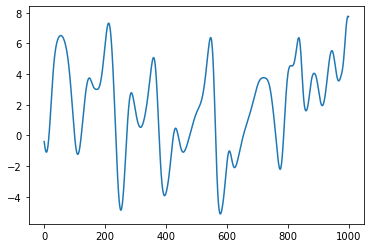

In [4]:
plt.plot(X_test[:,0])

In [5]:
Q = torch.zeros((params['dim_output'],params['dim_output'],params['dim_output']));
w = np.ones((params['dim_output'],3))
Q[0,0-1,0-2] = -w[0,1]*w[0,2]
Q[0,0-1,0+1] = w[0,0]*w[0,2]
Q[1,1-1,1-2] = -w[1,1]*w[1,2]
Q[1,1-1,1+1] = w[1,0]*w[1,2]
Q[(params['dim_output']-1),(params['dim_output']-1)-1,(params['dim_output']-1)-2] = -w[params['dim_output']-1,1]*w[params['dim_output']-1,2]
Q[(params['dim_output']-1),(params['dim_output']-1)-1,0] = w[params['dim_output']-1,0]*w[params['dim_output']-1,2]
for j in range(2,params['dim_output']-1):
    Q[j,j-1,j-2] = -w[j,1]*w[j,2]
    Q[j,j-1,j+1] = w[j,0]*w[j,2]

idx0, idx1, idx2, idx3, idx4, idx5 = [], [], [],[], [], []
for i in range(Q.shape[0]):
                    for j in range(Q.shape[0]):
                        for k in range(Q.shape[0]):
                            if Q[i,j,k]!=0. or  Q[i,k,j]!=0. or  Q[j,i,k]!=0. or  Q[j,k,i]!=0. or  Q[k,i,j]!=0. or  Q[k,j,i]!=0.: 
                                idx0.append((i,j,k))
                                idx1.append((i,k,j))
                                idx2.append((j,i,k))
                                idx3.append((j,k,i))
                                idx4.append((k,i,j))
                                idx5.append((k,j,i))      

np.random.seed(seed)
torch.manual_seed(seed)
class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            y_aug = np.random.uniform(size=(nb_batch,Batch_size,params['dim_latent']))
            self.y_aug = torch.nn.Parameter(torch.from_numpy(y_aug).float())
            w = np.random.uniform(size=(params['dim_output'],3))
            self.w = torch.nn.Parameter(torch.from_numpy(w).float())
            self.m     = torch.nn.Parameter(torch.Tensor(params['dim_observations']))
            self.linearCell                 = torch.nn.Linear(params['dim_input']+params['dim_latent'], params['dim_output']) 
            torch.nn.init.uniform_(self.m)
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                aug_inp = torch.cat((inp, self.y_aug), dim=1)-self.m
            else:
                aug_inp = inp
            Q = torch.zeros((params['dim_output'],params['dim_output'],params['dim_output']));
            x = torch.zeros((inp.shape[0],params['dim_output']));
            x[:,0] = (self.w[0,0]*aug_inp[:,1]-self.w[0,1]*aug_inp[:,params['dim_output']-2])*self.w[0,2]*aug_inp[:,params['dim_output']-1]#-self.w[3]*aug_inp[:,0]+self.w[4];
            Q[0,0-1,0-2] = -self.w[0,1]*self.w[0,2]
            Q[0,0-1,0+1] = self.w[0,0]*self.w[0,2]
            x[:,1] = (self.w[1,0]*aug_inp[:,2]-self.w[1,1]*aug_inp[:,params['dim_output']-1])*self.w[1,0]*aug_inp[:,0]#-self.w[8]*aug_inp[:,1]+self.w[9];
            Q[1,1-1,1-2] = -self.w[1,1]*self.w[1,2]
            Q[1,1-1,1+1] = self.w[1,0]*self.w[1,2]
            x[:,params['dim_output']-1] = (self.w[-1,0]*aug_inp[:,0]-self.w[-1,1]*aug_inp[:,params['dim_output']-3])*self.w[-1,2]*aug_inp[:,params['dim_output']-2]#-self.w[23]*aug_inp[:,params['dim_output']-1]+self.w[24];
            Q[(params['dim_output']-1),(params['dim_output']-1)-1,(params['dim_output']-1)-2] = -self.w[params['dim_output']-1,1]*self.w[params['dim_output']-1,2]
            Q[(params['dim_output']-1),(params['dim_output']-1)-1,0] = self.w[params['dim_output']-1,0]*self.w[params['dim_output']-1,2]
            for j in range(2,params['dim_output']-1):
                x[:,j] = (self.w[j,0]*aug_inp[:,j+1]-self.w[j,1]*aug_inp[:,j-2])*self.w[j,2]*aug_inp[:,j-1]#-self.w[5*j+3]*aug_inp[:,j] + self.w[5*j+4];
                Q[j,j-1,j-2] = -self.w[j,1]*self.w[j,2]
                Q[j,j-1,j+1] = self.w[j,0]*self.w[j,2]
            grad = x + self.linearCell(aug_inp);
            As = (self.linearCell.weight + torch.transpose(self.linearCell.weight,1,0))/2
            eig_vals = (torch.symeig(As,eigenvectors=True)[0])
            
            return grad, aug_inp, eig_vals, Q
model  = FC_net(params)


class FC_net_shifted(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_shifted, self).__init__()
            self.Dyn_net_init = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                aug_inp = torch.cat((inp, self.Dyn_net_init.y_aug), dim=1) - self.Dyn_net_init.m
            else:
                aug_inp = inp
            Q = torch.zeros((params['dim_output'],params['dim_output'],params['dim_output']));
            Q[0,0-1,0-2] = -self.Dyn_net_init.w[0,1]*self.Dyn_net_init.w[0,2]
            Q[0,0-1,0+1] = self.Dyn_net_init.w[0,0]*self.Dyn_net_init.w[0,2]
            Q[1,1-1,1-2] = -self.Dyn_net_init.w[1,1]*self.Dyn_net_init.w[1,2]
            Q[1,1-1,1+1] = self.Dyn_net_init.w[1,0]*self.Dyn_net_init.w[1,2]
            Q[(params['dim_output']-1),(params['dim_output']-1)-1,(params['dim_output']-1)-2] = -self.Dyn_net_init.w[params['dim_output']-1,1]*self.Dyn_net_init.w[params['dim_output']-1,2]
            Q[(params['dim_output']-1),(params['dim_output']-1)-1,0] = self.Dyn_net_init.w[params['dim_output']-1,0]*self.Dyn_net_init.w[params['dim_output']-1,2]
            for j in range(2,params['dim_output']-1):
                Q[j,j-1,j-2] = -self.Dyn_net_init.w[j,1]*self.Dyn_net_init.w[j,2]
                Q[j,j-1,j+1] = self.Dyn_net_init.w[j,0]*self.Dyn_net_init.w[j,2]
            d = self.Dyn_net_init.linearCell.bias + torch.nn.functional.bilinear(self.Dyn_net_init.m,self.Dyn_net_init.m,Q) + torch.nn.functional.linear(self.Dyn_net_init.m,self.Dyn_net_init.linearCell.weight)
            A = torch.matmul(self.Dyn_net_init.m,Q + Q.transpose(2,1)) + self.Dyn_net_init.linearCell.weight
            L_outp   = torch.nn.functional.linear(aug_inp,A,d)
            BP       =torch.nn.functional.bilinear(aug_inp,aug_inp,Q)
            #BP       = self.Dyn_net_init.BilinearCell(aug_inp,aug_inp)
            grad = L_outp + BP
            As = (A + torch.transpose(A,1,0))/2
            eig_vals = (torch.symeig(As,eigenvectors=True)[0])
            return grad, aug_inp, eig_vals, A, d, Q
model_shifted  = FC_net_shifted(params)


class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                k1, aug_inp, eig_vals   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = aug_inp + 0.5*params['dt_integration']*k1[:,:]
                k2, tmp, tmpp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = aug_inp + 0.5*params['dt_integration']*k2[:,:]            
                k3, tmp, tmpp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = aug_inp + params['dt_integration']*k3[:,:]            
                k4, tmp, tmpp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6
            else : 
                k1, aug_inp, eig_vals   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1
                k2, tmp, tmpp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2       
                k3, tmp, tmpp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3          
                k4, tmp, tmpp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6    
                
            return pred, k1, inp, aug_inp, eig_vals

class INT_net_shifted(torch.nn.Module):
        def __init__(self, params):
            super(INT_net_shifted, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Dyn_net = model_shifted
        def forward(self, inp, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            
            if inp.shape[-1]<params['dim_latent']+params['dim_input']:
                k1, aug_inp, eig_vals, A, d, Q  = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = aug_inp + 0.5*params['dt_integration']*k1[:,:]
                k2, tmp, tmpp, A, d, tmp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = aug_inp + 0.5*params['dt_integration']*k2[:,:]            
                k3, tmp, tmpp, A, d, tmp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = aug_inp + params['dt_integration']*k3[:,:]            
                k4, tmp, tmpp, A, d, tmp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6
            else :
                k1, aug_inp, eig_vals, A, d, Q   = self.Dyn_net(inp,dt)
                inp_k2 = 0.5*params['dt_integration']*k1
                inp_k2[:,:] = inp + 0.5*params['dt_integration']*k1
                k2, tmp, tmpp, A, d, tmp   = self.Dyn_net(inp_k2,dt)
                inp_k3 = 0.5*params['dt_integration']*k2
                inp_k3[:,:] = inp + 0.5*params['dt_integration']*k2       
                k3, tmp, tmpp, A, d, tmp   = self.Dyn_net(inp_k3,dt)
                inp_k4 = params['dt_integration']*k3
                inp_k4[:,:] = inp + params['dt_integration']*k3          
                k4, tmp, tmpp, A, d, tmp   = self.Dyn_net(inp_k4,dt)            
                pred = aug_inp +dt*(k1+2*k2+2*k3+k4)/6    
                
            return pred, k1, inp, aug_inp, eig_vals, A, d, Q

In [6]:
dt = params['dt_integration']
aug_vect = []
x = (torch.from_numpy(X_train.reshape(nb_batch,Batch_size,dim)).float())
z = (torch.from_numpy(Grad_t.reshape(nb_batch,Batch_size,dim)).float())

In [7]:
modelRINN = INT_net(params)
modelRINN_shifted = INT_net_shifted(params)
criterion = torch.nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(modelRINN_shifted.parameters(),lr = 0.1)


path = file_name_results+'.pt'
if pretrained :
    modelRINN_shifted.load_state_dict(torch.load(path))
# In[]
loss_it = []
zeta = 100
alpha = 1.
beta = 1.
gama = 100.
lam = 1000.
idx = 0
c = 0

In [8]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

0.1


In [9]:
params['ntrain']=[10000000000000,10000]
for t in range(0,params['ntrain'][0]):
        # Forward pass: Compute predicted y by passing x to the model  
    for b in range(nb_batch):
        inp_concat = torch.cat((x[b,:,:],modelRINN_shifted.Dyn_net.Dyn_net_init.y_aug[b,:,:]),dim = -1)- modelRINN_shifted.Dyn_net.Dyn_net_init.m
        pred, grad, inp, aug_inp, eig_vals, A, d, Q = modelRINN_shifted(inp_concat,dt)
#        pred1, grad1, inp, aug_inp, eig_vals = modelRINN(aug_inp,dt)
        l1_reg = 0.
        for i in range(len(idx0)):
            l1_reg = l1_reg + torch.norm((Q[idx0[i]] + Q[idx1[i]] + Q[idx2[i]] + Q[idx3[i]] +  Q[idx4[i]] + Q[idx5[i]]))
        # Compute and print loss
        loss0 = criterion(pred[:-1,dim:], aug_inp[1:,dim:]).sum()
        loss1 = criterion(grad[:,:dim], z[b,:,:]).mean()
        loss2 = criterion(pred[:-1,:dim] , aug_inp[1:,:dim]).sum()
        loss3 = torch.sum(torch.relu(eig_vals)/(torch.relu(eig_vals)+1))
        loss =  zeta*loss0+1.0*loss1+1.0*loss2 + gama*(l1_reg)+ 100*loss3 
        loss_it.append(loss.data.numpy())
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        torch.save(modelRINN_shifted.state_dict(),file_name_results+'.pt')  
        if t == 200 and idx ==0:
            gama = 1.0
            zeta = 1.0
            #for param_group in optimizer.param_groups:
            #    param_group['lr'] = 0.1
            idx+=1
            c=t
        if t == 400 and idx == 1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.01
            idx+=1
            c=t
            print('reducing Learning rate to 0.01')
        if (t)> 6000 and idx == 2 :
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.001
            print('reducing Learning rate to 0.001')
            idx+=1
    if loss.data.numpy()<20 : 
        break
    if t%1000 == 0:
        print('error', t,b,loss)

/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272126608/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2499.)


error 0 0 tensor(1342382.3750, grad_fn=<AddBackward0>)
reducing Learning rate to 0.01
error 1000 0 tensor(280.0912, grad_fn=<AddBackward0>)
error 2000 0 tensor(278.9888, grad_fn=<AddBackward0>)
error 3000 0 tensor(275.7503, grad_fn=<AddBackward0>)
error 4000 0 tensor(262.0879, grad_fn=<AddBackward0>)
error 5000 0 tensor(128.8213, grad_fn=<AddBackward0>)
error 6000 0 tensor(96.2955, grad_fn=<AddBackward0>)
reducing Learning rate to 0.001
error 7000 0 tensor(87.8666, grad_fn=<AddBackward0>)
error 8000 0 tensor(80.2236, grad_fn=<AddBackward0>)
error 9000 0 tensor(74.0042, grad_fn=<AddBackward0>)
error 10000 0 tensor(69.0066, grad_fn=<AddBackward0>)
error 11000 0 tensor(64.4813, grad_fn=<AddBackward0>)
error 12000 0 tensor(59.9703, grad_fn=<AddBackward0>)
error 13000 0 tensor(54.5703, grad_fn=<AddBackward0>)
error 14000 0 tensor(46.6734, grad_fn=<AddBackward0>)
error 15000 0 tensor(37.3578, grad_fn=<AddBackward0>)
error 16000 0 tensor(31.0715, grad_fn=<AddBackward0>)
error 17000 0 tensor(2

In [10]:
inp_concat = torch.cat((x[-1,:,:],modelRINN_shifted.Dyn_net.Dyn_net_init.y_aug[-1,:,:]),dim = -1)- modelRINN_shifted.Dyn_net.Dyn_net_init.m
y_pred2=np.zeros((10000,40))
tmp = torch.zeros((1,40))
tmp[:,:] = tmp[:,:]*0 +20 # start from a "far from the observations initial condition"

for i in range(10000):
    y_pred2[i,:] = modelRINN_shifted(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[i,:],(1,40))).float())

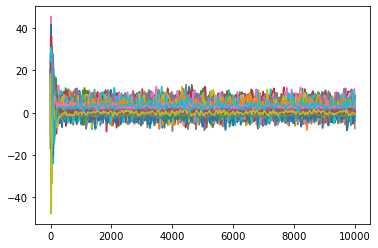

In [11]:
plt.plot(y_pred2[:,:])

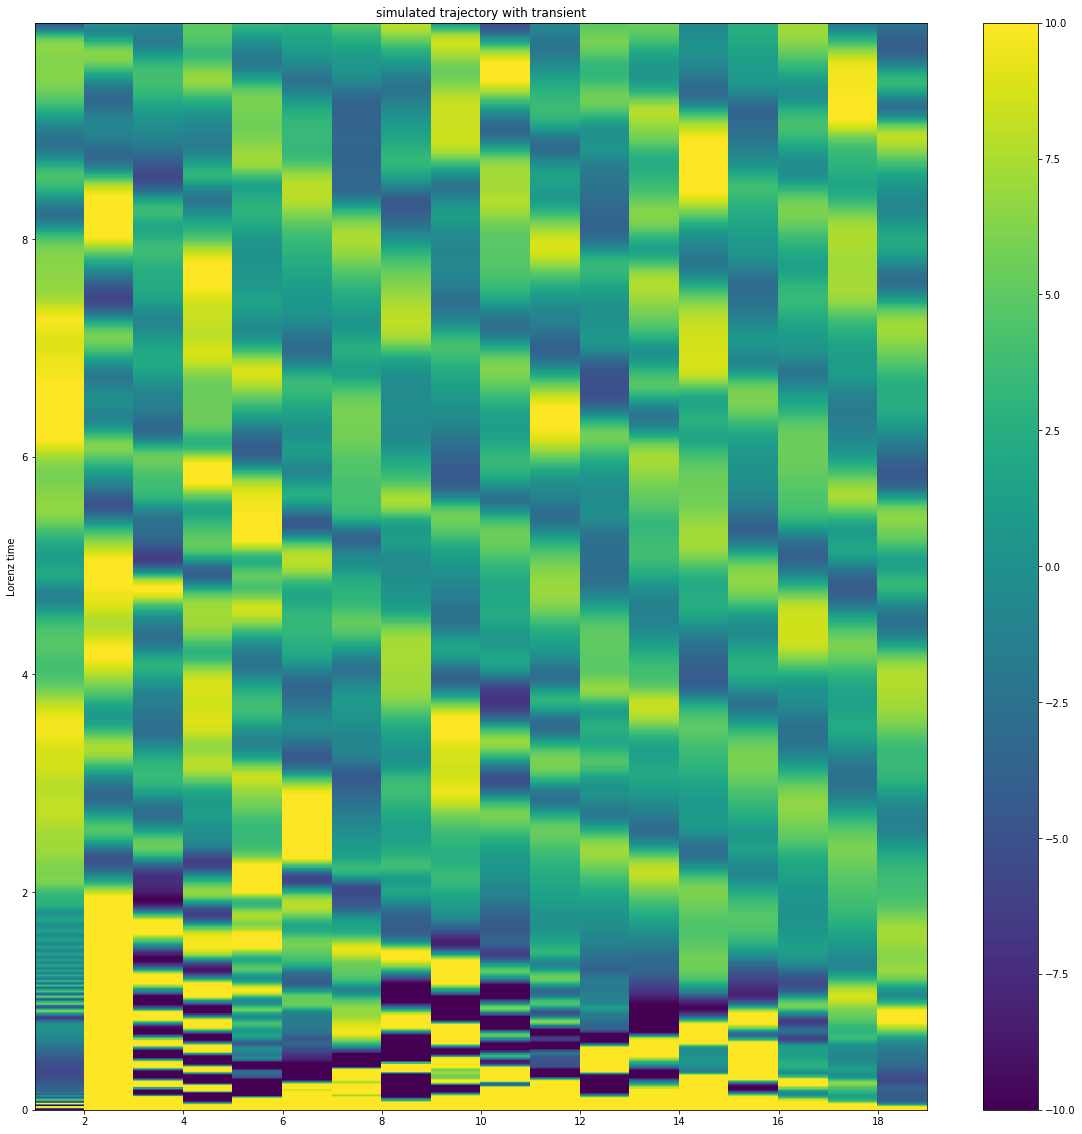

In [12]:
# plot neural embedding simulation

fig = plt.figure(figsize=(20, 20))
leng = 1000
Time_simu = np.arange(0.0,leng*0.01,0.01)
[X,Y]=np.meshgrid(range(20),Time_simu)
#plt.figure(figsize=(10,15))
ax = fig.add_subplot(1, 1, 1);
im = ax.pcolor(X,Y,y_pred2[:leng,:20]); # starting from the 1000 point to avoid the transient
ax.set_ylabel("Lorenz time")
ax.set_xlim([1,20-1]);
im.set_clim([-10,10]);
ax.set_title('simulated trajectory with transient')
plt.colorbar(im)

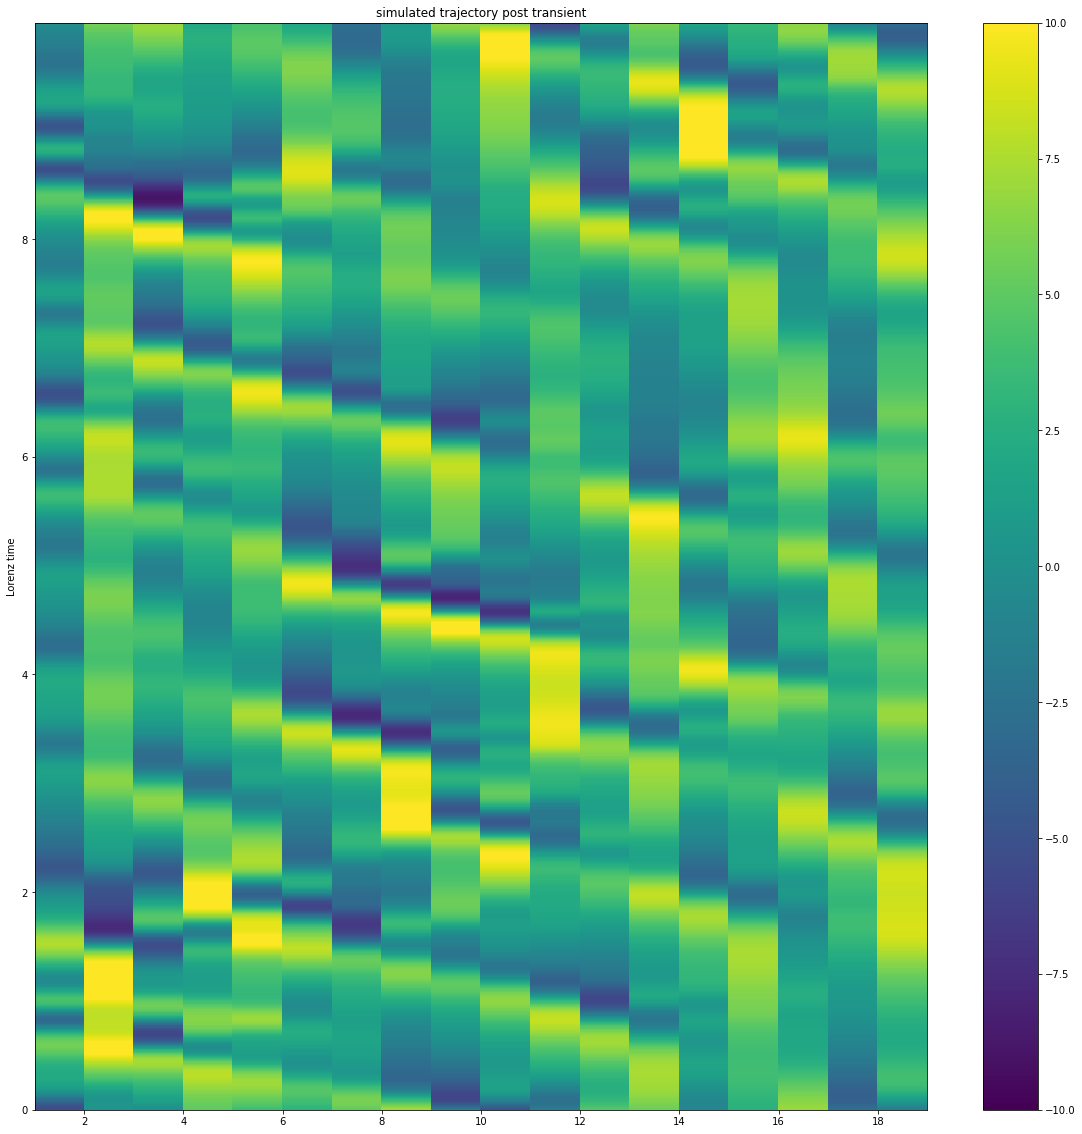

In [13]:
# plot neural embedding simulation

fig = plt.figure(figsize=(20, 20))
leng = 1000
Time_simu = np.arange(0.0,leng*0.01,0.01)
[X,Y]=np.meshgrid(range(20),Time_simu)
#plt.figure(figsize=(10,15))
ax = fig.add_subplot(1, 1, 1);
im = ax.pcolor(X,Y,y_pred2[1000:1000+leng,:20]); # starting from the 1000 point to avoid the transient
ax.set_ylabel("Lorenz time")
ax.set_xlim([1,20-1]);
im.set_clim([-10,10]);
ax.set_title('simulated trajectory post transient')
plt.colorbar(im)

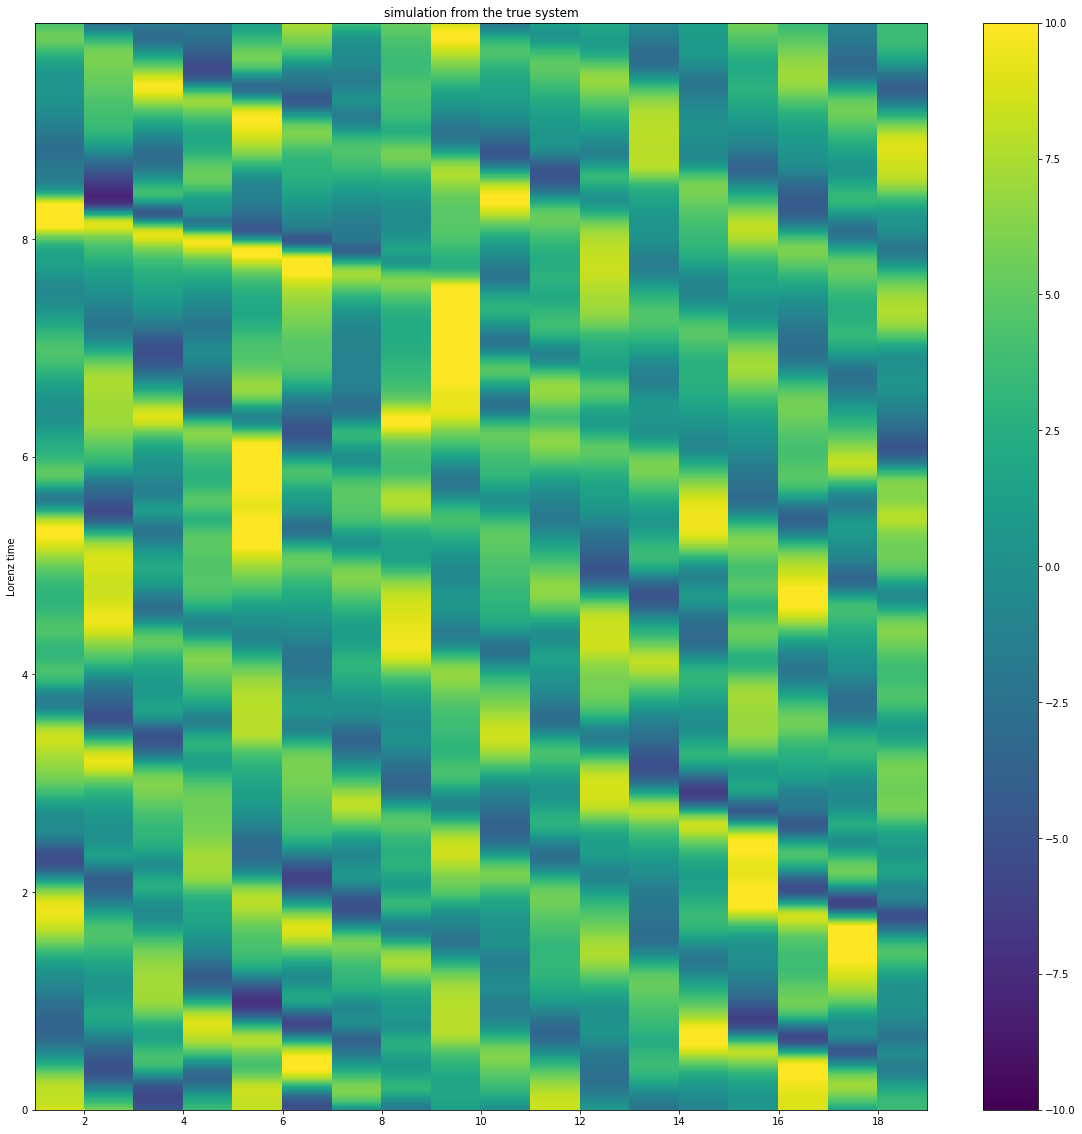

In [14]:
# plot True simulation

fig = plt.figure(figsize=(20, 20))
leng = 1000
Time_simu = np.arange(0.0,leng*0.01,0.01)
[X,Y]=np.meshgrid(range(20),Time_simu)
#plt.figure(figsize=(10,15))
ax = fig.add_subplot(1, 1, 1);
im = ax.pcolor(X,Y,X_test[:leng,:20]);
ax.set_ylabel("Lorenz time")
ax.set_xlim([1,20-1]);
im.set_clim([-10,10]);
ax.set_title('simulation from the true system')
plt.colorbar(im)

In [15]:
from scipy.fftpack import fft
# Number of sample points
end_seq = 4000-1
N = end_seq
# sample spacing
T =  0.01
Y1, Y2 = [], []
for i in range(20):
    y2 = y_pred2[1000:1000+end_seq,i]# compute the spectrums without the transient
    yf2 = fft(y2)
    yf2_abs  = 2.0/N * np.abs(yf2[1:N//2])
    Y2.append(yf2_abs)
Y2 = np.array(Y2)
#spectrum of the true series
for i in range(20):
    y = X_train[:end_seq,i]
    yf = fft(y)
    yf_abs = 2.0/N * np.abs(yf[1:N//2])
    Y1.append(yf_abs)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
Y1 = np.array(Y1)

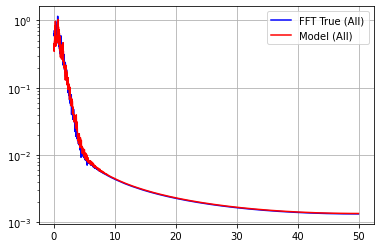

In [16]:
end_plt = -1
plt.semilogy(xf[1:N//2][:end_plt], np.array(Y1)[:20,:].mean(axis = 0)[:end_plt], '-b')
plt.semilogy(xf[1:N//2][:end_plt], np.array(Y2)[:20,:].mean(axis = 0)[:end_plt], '-r')

plt.legend(['FFT True (All)', 'Model (All)'])
plt.grid()
plt.show()